Code to prepare and plot the altimetry input data files, both for Diva2D and [divand](https://www.github.com/gher-ulg/divand.jl/).

In [1]:
import os
import re
import datetime
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib import rcParams
import netCDF4
import logging
import divaaltimetry

## Configuration

Logging

In [2]:
logger = logging.getLogger("diva-altimetry")
logger.setLevel(logging.INFO)

Plotting (should be ideally in `matplotlibrc` but seems not to work with virtualenv).

In [3]:
rcParams.update({'font.size': 16, 'figure.dpi': 300, 'savefig.bbox': 'tight'})
# rcParams.keys

# Input parameters

## Files and directories

In [4]:
databasedir = "/home/ctroupin/Data/AVISO/regional-mediterranean/delayed-time/along-track/filtered/adt"
outputdir = "../data/"
figdir = "../figures/"
missionlist = ["al", "c2", "h2", "j2"]

## Domain and period of interest
* coordinates: tuple with lon_min, lon_max, lat_min, lat_max 
* timescale: temporal scale in days; used to compute weights for Diva2D

In [5]:
coordinates = [-6.75, 40.001, 30, 48.]
year, month, day, interval = 2014, 5, 25, 10
timescale = 5.        

## Map projection
Define the projection from the coordinates; used for the plots.

In [6]:
m = Basemap(projection='merc',
            llcrnrlon=coordinates[0], llcrnrlat=coordinates[2],
            urcrnrlon=coordinates[1], urcrnrlat=coordinates[3],
            lat_ts=0.5 * (coordinates[2] + coordinates[3]), resolution='i')

## Generate list of files for the selected period

Based on the filenames, we can easily identify the files corresponding to the time of interest:
* datemid is the central time of the considered period
* datestart is the start date
* dateend is the last day.

In [7]:
filelist = divaaltimetry.make_filelist(databasedir, missionlist, year, month, day, interval)

# Main loop

Compute central time

In [8]:
datemid = datetime.datetime(year, month, day).toordinal() - datetime.datetime(1950, 1, 1).toordinal()
logging.info("Central time (in days since January 1st, 1950): {0}".format(datemid))

In [9]:
fignamesuffix, figtitledate = divaaltimetry.prepare_datestrings(year, month, day, interval)
logging.info(fignamesuffix)

## File and figure names
Generate file and figure names using the suffixes.

In [10]:
outputfilename = "ADT_{0}.dat".format(fignamesuffix)
divafilename =  "data_{0}.dat".format(fignamesuffix)
figname = "ADT_{0}".format(fignamesuffix)
logging.info("Text file name: {0}".format(outputfilename))
logging.info("Figure name: {0}".format(figname))

## Make the plot and write data to text files

/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


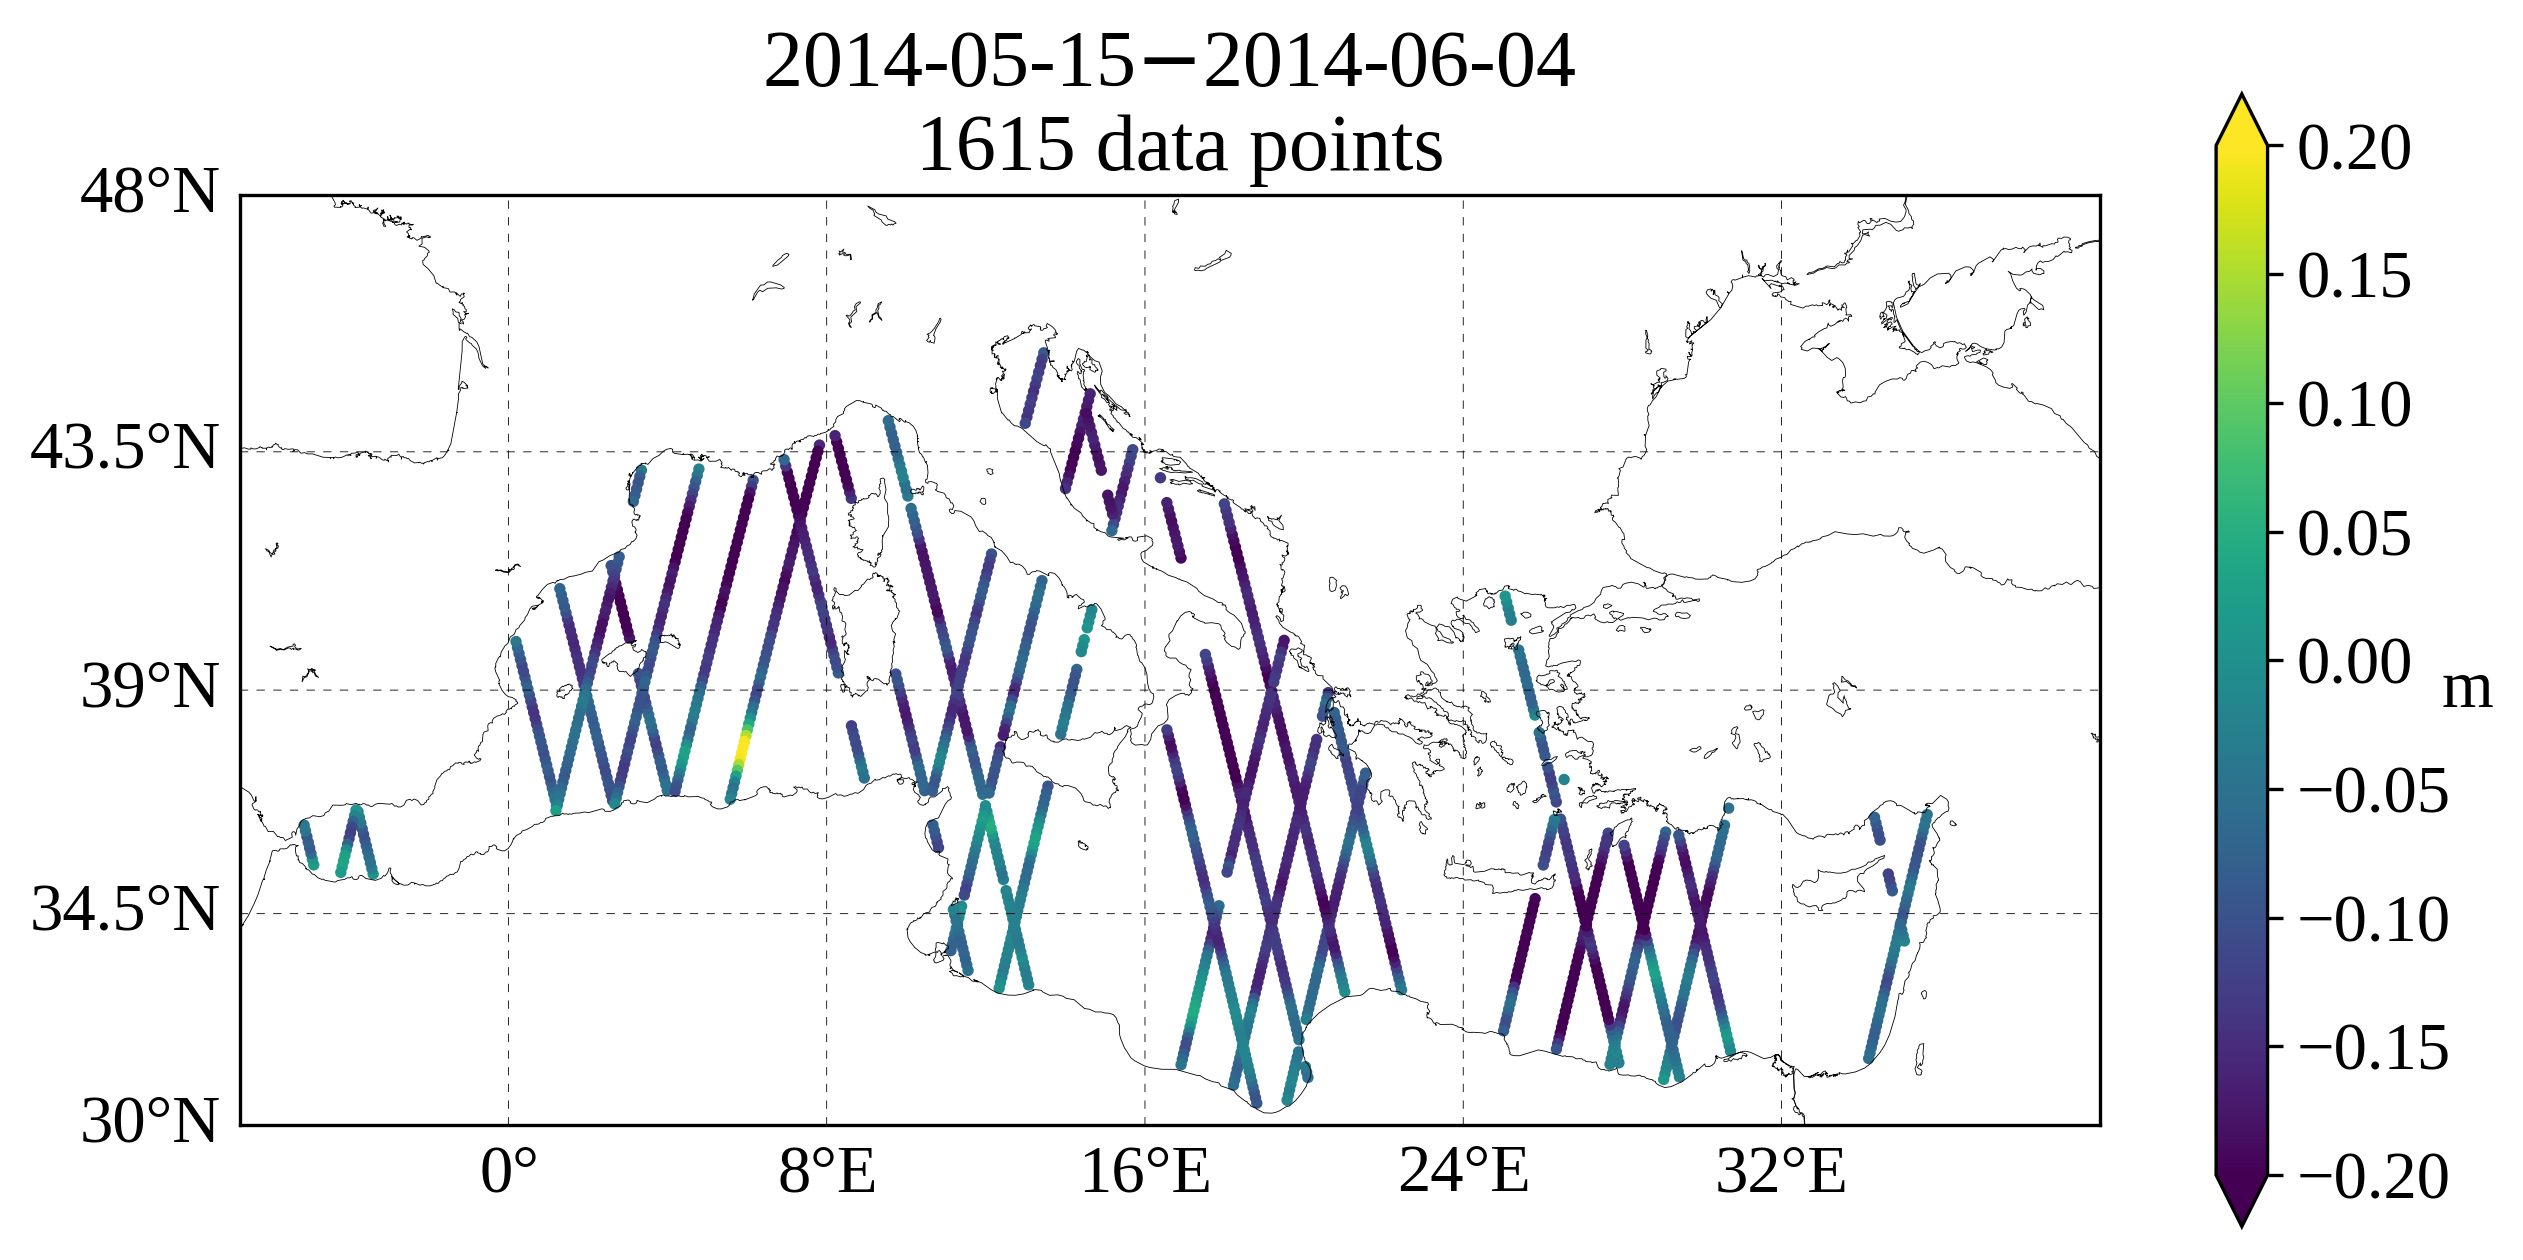

In [12]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111)

npoints = 0

for file in filelist[0:10]:
    track = divaaltimetry.Track(file)
    # Add track to the plot
    track.add_to_map(m, marker='o', s=3, vmin=-.2, vmax=.2)
    # Count the number of points
    npoints += track.npoints
    # Write data to a text file
    track.write_textfile(os.path.join(outputdir, outputfilename))
    # Compute data weights and write a Diva2D data file
    track.write_divafile(os.path.join(outputdir, divafilename), timescale, datemid)

# Add lines, coastline etc    
m.drawmeridians(np.arange(-8., round(coordinates[1]), 8), 
                labels=[0, 0, 0, 1], linewidth=.2)
m.drawparallels(np.linspace(round(coordinates[2]), round(coordinates[3]), 5), 
                labels=[1, 0, 0, 0], linewidth=.2)
m.drawcoastlines(linewidth=.2)
cbar = plt.colorbar(shrink=.5, extend='both')
cbar.set_label("m", rotation=0)
plt.title("{0} \n {1} data points".format(figtitledate, npoints))
# plt.savefig(os.path.join(figdir, figname), dpi=300)
plt.show()
plt.close()